# Testing if Dan Foreman-Mackey's "money equation" works for my purposes.
Neglecting constant terms, his money equation is:

$$P(\{x_k\} | \gamma) = \prod_{k=1}^K \frac{1}{N_k} \sum_{n=1}^{N_k} \frac{Q_c(q_k^{(n)}) q_k^{-\gamma}}{P(obs|q_k)} $$

## Status as of end of day on Thursday, August 12
  - I can simulate the full sample parameters, and can grab random measurements of RV and imaging observables.
  - Next:
     - Add in observational uncertainties, and shift the measurements by appropriate amounts
     - Write code (subclass Fitters.Bayesian_LS) to fit the orbit to that information.
     - See what happens when I dial back the number of data points to a very small value.

## Status as of end of day on Sunday, August 23
  - I can simulate the full sample parameters, and can grab random measurements of RV and imaging observables.
  - Observables have gaussian uncertainties
  - Code exists to fit the orbit.
    - It works for fitting large numbers of observations
    - It is slow though. I think that is because of the astropy quantity stuff, so I will have to remove a lot of that and try again.
  - Next:
     - Speed up fitting code
     - See what happens when I dial back the number of data points to a very small value.
     - Calculate orbit fits for a bunch of things, and see how well the a,e,q distributions are reproduced.

In [1]:
# Import stuff
import numpy as np
from scipy.stats import truncnorm, lognorm, powerlaw, norm
import matplotlib.pyplot as plt
import ForwardModeling
import Fitters
import Orbit
import pandas as pd
from astropy import units as u, constants
import IMF_utils
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

%matplotlib inline

Module 'anfft' (FFTW Python bindings) could not be imported.
To install it, try running 'easy_install anfft' from the terminal.
Falling back on the slower 'fftpack' module for ND Fourier transforms.


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
# True parameters
true_mrd_alpha = 0.4    # Mass-ratio distribution
true_error = 0.03
N_sample = 1000     # Number of stars in sample
N_mcmc = 1e6
true_mult_rate = 0.5   # Multiplicity rate
true_sep_mu = np.log(200)   # Separation mean
true_sep_sigma = np.log(10)   # Separation spread
true_ecc_alpha = 0.7   # eccentricity distribution parameter
true_min_mass = 2.0    # Minimum primary mass
true_max_mass = 6.0    # maximum primary mass

In [3]:
#Make a simulated sample.
np.random.seed(1)
a = np.random.lognormal(mean=true_sep_mu, sigma=true_sep_sigma, size=N_sample) * u.AU
e = ForwardModeling.truncated_expon(scale=true_ecc_alpha, Nsamp=N_sample)
q = ForwardModeling.truncated_expon(scale=true_mrd_alpha, Nsamp=N_sample)
prim_mass = IMF_utils.inverse_imf(np.random.uniform(size=N_sample), mmin=true_min_mass, mmax=true_max_mass) * u.M_sun
M0 = np.random.uniform(0, 2*np.pi, size=N_sample) * u.radian
Omega = np.random.uniform(0, 2*np.pi, size=N_sample) * u.radian
omega = np.random.uniform(0, 2*np.pi, size=N_sample) * u.radian
sini = np.random.uniform(0, 1, size=N_sample)
i = np.arcsin(sini) * u.radian
Period = np.sqrt(4*np.pi**2*a**3 / (constants.G*(prim_mass + prim_mass*q))).to(u.year)

sample_parameters = pd.DataFrame(data=dict(a=a, e=e, q=q, M_prim=prim_mass, Period=Period.to(u.year),
                                           M0=M0.to(u.degree), big_omega=Omega.to(u.degree), 
                                           little_omega=omega.to(u.degree), i=i.to(u.degree)))
sample_parameters.head()

,M0,M_prim,Period,a,big_omega,e,i,little_omega,q
0,315.880246,4.921028,319378.521952,8421.226711,234.210828,0.042234,8.418620,122.823756,0.189473
1,314.657873,4.005916,160.749632,48.896028,185.437442,0.094582,41.764676,182.202554,0.129054
2,358.776194,3.282425,227.112692,59.273182,303.544833,0.010438,7.028862,224.455383,0.229682
3,278.443182,3.196033,37.465213,16.906798,47.426549,0.665410,4.973156,210.703830,0.076991
4,73.101556,2.288368,34649.461116,1467.025372,90.362440,0.040894,44.697269,48.195046,0.148920


In [4]:
# Make some RVs and imaging observations at random times throughout the period
def sample_orbit(star, N_rv, N_imag, rv1_err=None, rv2_err=None, pos_err=None, distance=100):
    """ Sample the binary orbit represented by the 'star' structure at N_rv random times for
    RV measurements, and N_imag random times for imaging measurements
    
    Parameters:
    ===========
    - rv1_err: Uncertainty on the primary star velocity measurements (in km/s or velocity Quantity)
    - rv2_err: Uncertainty on the secondary star velocity measurements (in km/s or velocity Quantity)
    - pos_err: On-sky positional error (in arcseconds or angle Quantity)
    - distance: The distance to the star (in parsecs or a distance Quantity)
    
    Returns:
    ========
    - Times of RV observations, primary and secondary rv measurements, 
      times of imaging observations, rho/theta measurements.
    """
    orbit = Orbit.OrbitCalculator(P=star['Period'], M0=star['M0'], a=star['a'], e=star['e'], 
                                  big_omega=star['big_omega'], little_omega=star['little_omega'],
                                  i=star['i'], q=star['q'], primary_mass=star['M_prim'])
    print('K1 = {}\nK2 = {}'.format(orbit.K1, orbit.K2))
    rv_times = np.random.uniform(0, star['Period'], size=N_rv)
    image_times = np.random.uniform(0, star['Period'], size=N_imag)
    rv_primary_measurements = orbit.get_rv(rv_times, component='primary')
    rv_secondary_measurements = rv_primary_measurements * orbit.K2 / orbit.K1
    rho_measurements, theta_measurements = orbit.get_imaging_observables(image_times, distance=distance)
    
    # Add errors where requested
    if rv1_err is not None:
        rv_primary_measurements += np.random.normal(loc=0, scale=rv1_err, size=len(rv_times))
    if rv2_err is not None:
        rv_secondary_measurements += np.random.normal(loc=0, scale=rv2_err, size=len(rv_times))
    if pos_err is not None:
        x = rho_measurements*np.cos(theta_measurements) + np.random.normal(loc=0, scale=pos_err, size=len(image_times))
        y = rho_measurements*np.sin(theta_measurements) + np.random.normal(loc=0, scale=pos_err, size=len(image_times))
        rho_measurements = np.sqrt(x**2 + y**2)
        theta_measurements = np.arctan2(y, x)
    
    return rv_times, rv_primary_measurements, rv_secondary_measurements, image_times, rho_measurements, theta_measurements


K1 = 1.16978757714
K2 = 5.09308211831


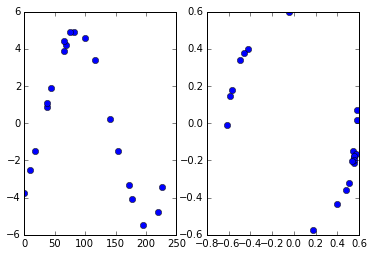

In [5]:
reload(Orbit)
rv1_err = 0.1
rv2_err = 0.2
pos_err = 1e-2
t_rv, rv1, rv2, t_im, rho, theta = sample_orbit(sample_parameters.ix[2], N_rv=20, N_imag=20,
                                                rv1_err=rv1_err, rv2_err=rv2_err, pos_err=pos_err)
fig, axes = plt.subplots(ncols=2, nrows=1)
axes[0].plot(t_rv, rv2, 'bo')
x = rho * np.sin(theta)
y = rho * np.cos(theta)
axes[1].plot(x, y, 'bo')

# Orbit fitting
Now that I can generate random data, let's write some code to fit the orbits and make sure that I get the right answer for a wide range of guesses. The likelihood function is separable into velocity and imaging observables, and the primary and secondary velocity components are themselves separable:

$$\log{L_{rv}} \propto \frac{-0.5(v-m(t))^2}{ \sigma_v^2} $$
$$\log{L_{image}} \propto \frac{-0.5((x-m(t))^2 + (y-m(t))^2)}{ \sigma_{pos}^2}  $$

In [31]:
constants.G

<Constant name=u'Gravitational constant' value=6.67384e-11 error=8e-15 units='m3 / (kg s2)' reference=u'CODATA 2010'>

In [6]:
#reload(Orbit)
fitter = Orbit.OrbitFitter(rv_times=t_rv, imaging_times=t_im, 
                           rv1_measurements=rv1, rv1_err=rv1_err,
                           rv2_measurements=rv2, rv2_err=rv2_err, 
                           rho_measurements=rho, theta_measurements=theta, pos_err=pos_err)

M0              358.776194
M_prim            3.282425
Period          227.112692
a                59.273182
big_omega       303.544833
e                 0.010438
i                 7.028862
little_omega    224.455383
q                 0.229682
Name: 2, dtype: float64


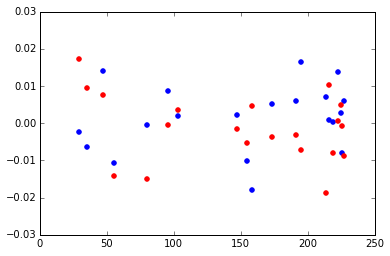

In [7]:
idx = 2
K1 = 1.16978757714   # ONLY VALID FOR IDX=2!
K2 = 5.09308211831   # ONLY VALID FOR IDX=2!

p = sample_parameters.ix[idx]
print(p)
true_pars = [p['Period'], p['M0'], p['a'], p['e'], p['big_omega'], p['little_omega'], p['i'], K1, K2]
rv1_pred, rv2_pred, xpos_pred, ypos_pred = fitter.model(true_pars, fitter.x)
plt.scatter(t_im, fitter.y['xpos']-xpos_pred, color='blue')
plt.scatter(t_im, fitter.y['ypos']-ypos_pred, color='red')
#plt.scatter(fitter.y['xpos'], xpos_pred, color='blue')

In [8]:
fitter._lnlike(true_pars)
fitter.lnprior(true_pars)

0.0

In [9]:
#reload(Orbit)
#reload(Fitters)
#fitter.fit(backend='multinest', basename='fitting_test/single-', overwrite=True)
%prun fitter.fit(backend='emcee', guess=False, initial_pars=true_pars, nwalkers=400, n_burn=100, n_prod=400)

INFO:root:Done with burn-in iteration 1 / 100
INFO:root:Done with burn-in iteration 11 / 100
INFO:root:Done with burn-in iteration 21 / 100
INFO:root:Done with burn-in iteration 31 / 100
INFO:root:Done with burn-in iteration 41 / 100
INFO:root:Done with burn-in iteration 51 / 100
INFO:root:Done with burn-in iteration 61 / 100
INFO:root:Done with burn-in iteration 71 / 100
INFO:root:Done with burn-in iteration 81 / 100
INFO:root:Done with burn-in iteration 91 / 100


Running burn-in
Running production

INFO:root:Done with production iteration 1 / 400
INFO:root:Done with production iteration 11 / 400
INFO:root:Done with production iteration 21 / 400
INFO:root:Done with production iteration 31 / 400
INFO:root:Done with production iteration 41 / 400
INFO:root:Done with production iteration 51 / 400
INFO:root:Done with production iteration 61 / 400
INFO:root:Done with production iteration 71 / 400
INFO:root:Done with production iteration 81 / 400
INFO:root:Done with production iteration 91 / 400
INFO:root:Done with production iteration 101 / 400
INFO:root:Done with production iteration 111 / 400
INFO:root:Done with production iteration 121 / 400
INFO:root:Done with production iteration 131 / 400
INFO:root:Done with production iteration 141 / 400
INFO:root:Done with production iteration 151 / 400
INFO:root:Done with production iteration 161 / 400
INFO:root:Done with production iteration 171 / 400
INFO:root:Done with production iteration 181 / 400
INFO:root:Done with production iteration 1

In [ ]:
_ = plt.plot(fitter.sampler.chain[:, :, 6].T, 'k-', alpha=0.1)

In [112]:
n_burn = 300

ndim = fitter.sampler.chain.shape[2]
samples = fitter.sampler.chain[:, n_burn:, :].reshape((-1, ndim))
lnprob = fitter.sampler.lnprobability[:, n_burn:].flatten()
chain_dict = {fitter.param_names[i]: samples[:, i] for i in range(fitter.n_params)}
chain_dict['lnprob'] = lnprob
fitter.samples = pd.DataFrame(data=chain_dict)

[227.11269166933977, 358.77619398236737, 59.273182140338925, 0.010437756458057532, 303.54483291867547, 224.45538252941139, 7.0288617577693095, 1.16978757714, 5.09308211831]


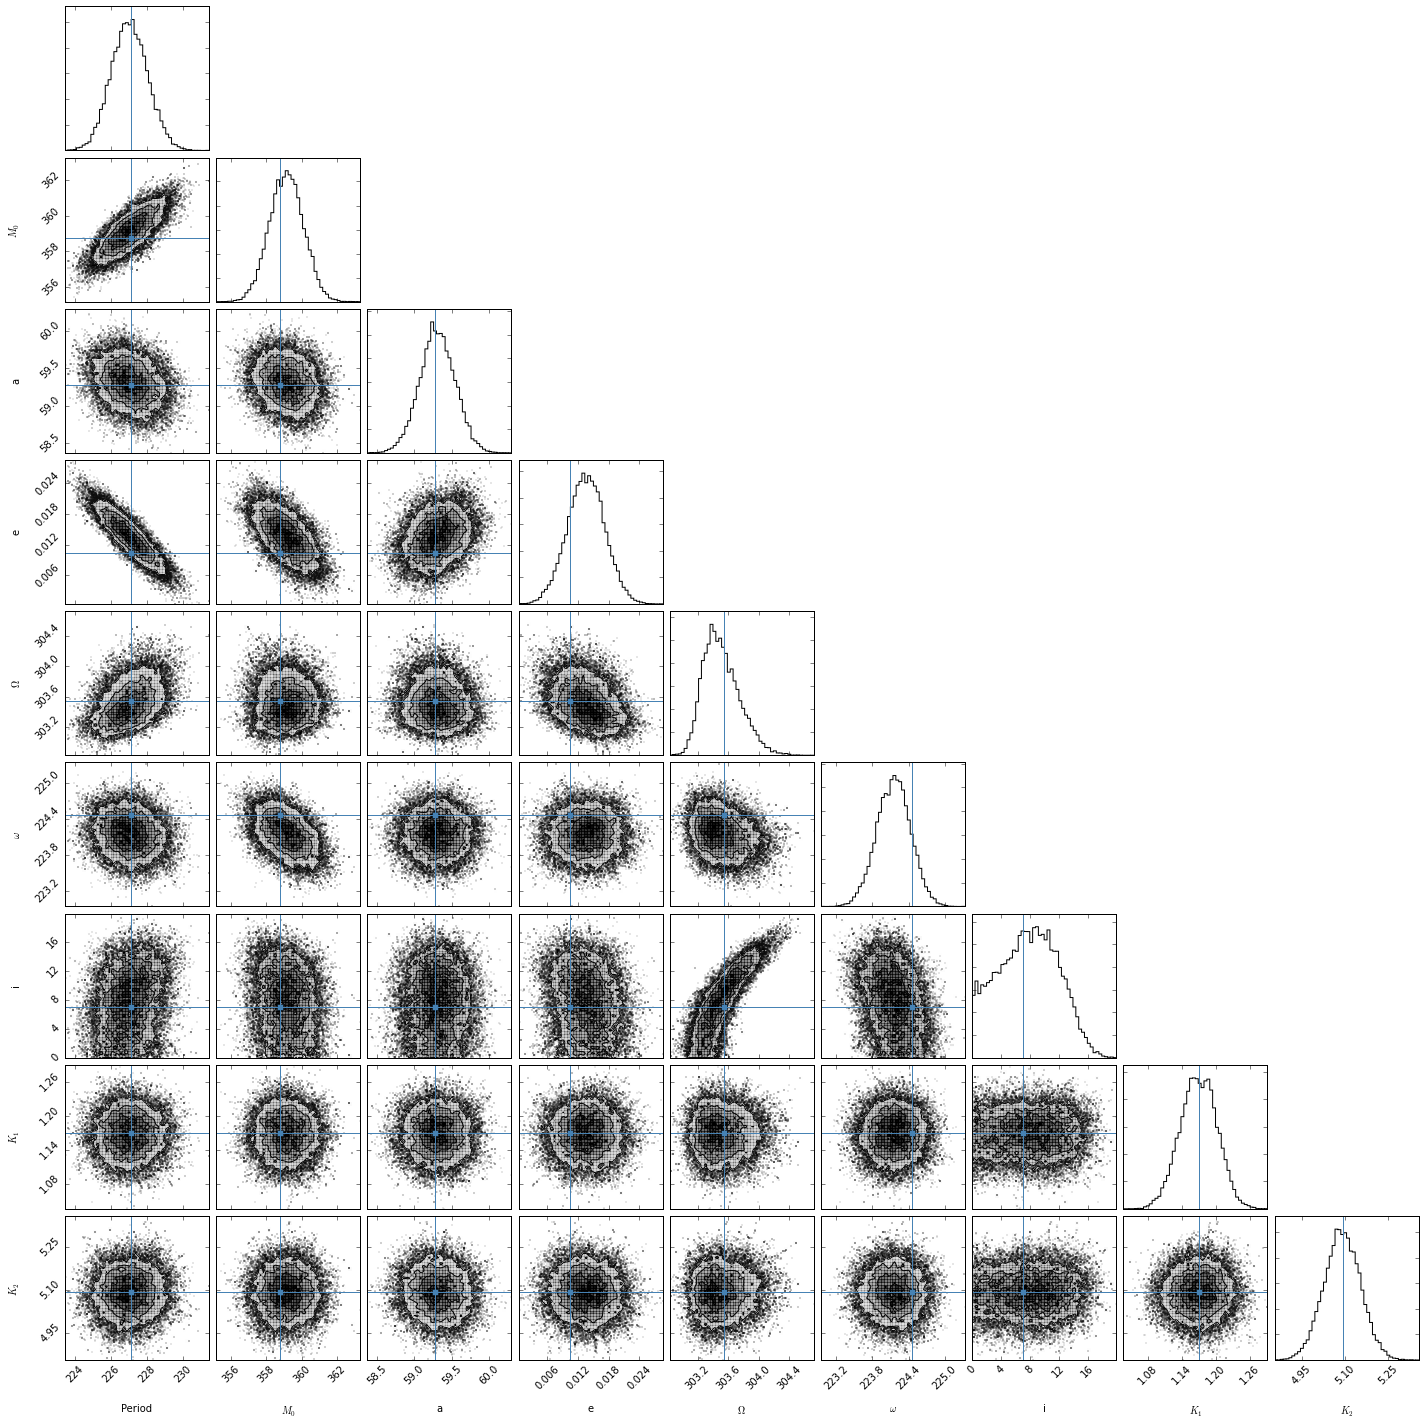

In [114]:
# Emcee results
fitter.triangle(truths=true_pars)
print(true_pars)

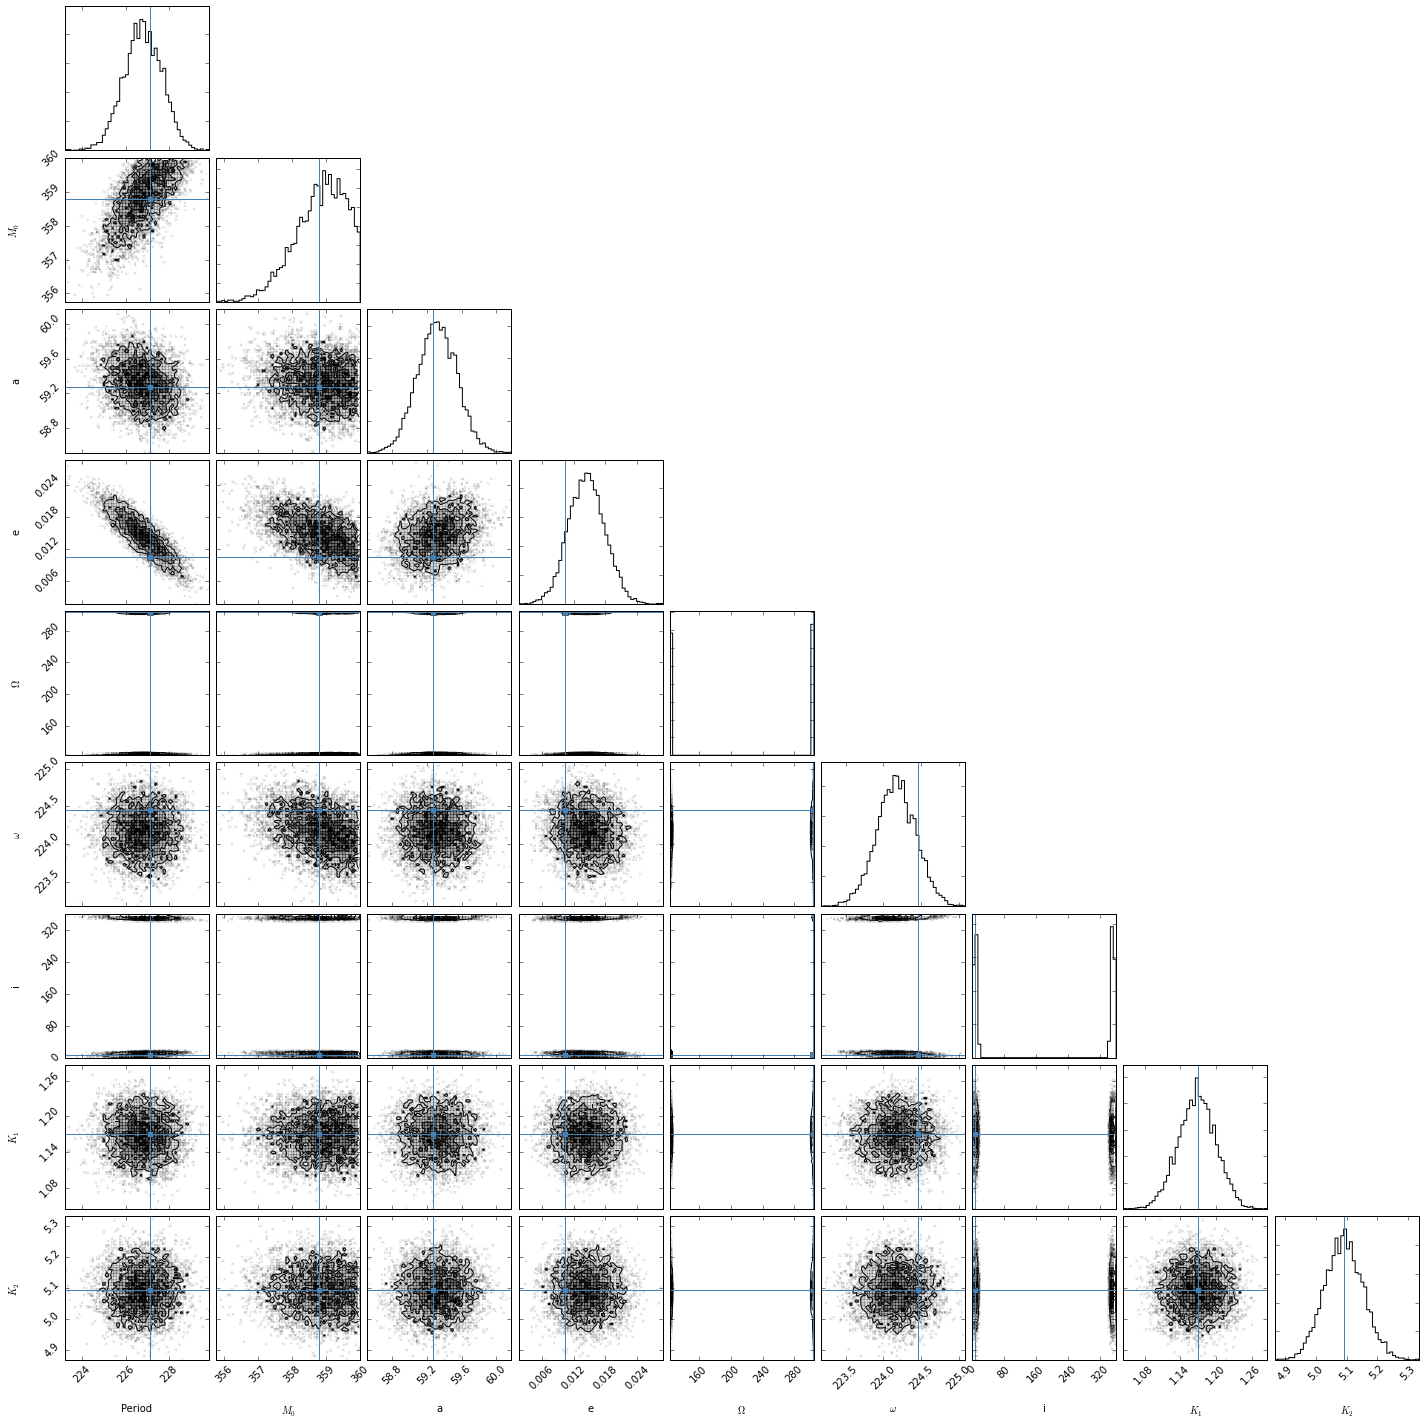

In [92]:
# multinest results
fitter.triangle(truths=true_pars)

In [93]:
fitter2 = OrbitFitter(rv_times=t_rv, imaging_times=t_im, rv1_measurements=rv1, rv1_err=rv1_err,
                     rv2_measurements=rv2, rv2_err=rv2_err, 
                     rho_measurements=rho, theta_measurements=theta, pos_err=pos_err)
%prun fitter2.fit(backend='multinest', basename='fitting_test/prun-', overwrite=True)

In [34]:
#reload(Orbit)
%timeit fitter.model(true_pars, fitter.x)

100 loops, best of 3: 2.78 ms per loop


In [97]:
%prun fitter.model(true_pars, fitter.x)